# Grounded Segement Anything

![gdgligen](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

**Why this project?**
- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks. 
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text. 
- The combination of the two models enable to **detect and segment everything** with text inputs!

# Prepare Environments

In [1]:
! python -m pip install -e segment_anything
! python -m pip install -e GroundingDINO
! pip install diffusers transformers accelerate scipy safetensors

Obtaining file:///home/kt/python/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment_anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment_anything
Obtaining file:///home/kt/python/Grounded-Segment-Anything/GroundingDINO
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done


  Building editable for groundingdino (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Building editable for groundingdino (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [134 lines of output]
      /tmp/pip-build-env-ytomy6ke/overlay/lib/python3.10/site-packages/torch/_subclasses/functional_tensor.py:258: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
        cpu = _conversion_method_template(device=torch.device("cpu"))
      Compiling with CUDA
      running editable_wheel
      creating /tmp/pip-wheel-wooaup_o/.tmp-5rrvvgv7/groundingdino.egg-info
      writing /tmp/pip-wheel-wooaup_o/.tmp-5rrvvgv7/groundingdino.egg-info/PKG-INFO
      writing dependency_links to /tmp/pip-wheel-wooaup_o/.tmp-5rrvvgv7/groundingdino.egg-info/dependency_links.txt
      writing requirements to /tmp/pip-wheel-wooaup_o/.tmp-5rrvvgv7/groundingdino.egg-info/requires.txt
      writing 

In [2]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [16]:
#from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

In [3]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# # Grounding DINO
# import GroundingDINO.groundingdino.datasets.transforms as T
# from GroundingDINO.groundingdino.models import build_model
# from GroundingDINO.groundingdino.util import box_ops
# from GroundingDINO.groundingdino.util.slconfig import SLConfig
# from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
# from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

# Load Grounding DINO model

In [5]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [6]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [7]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

AttributeError: 'ConfigDict' object has no attribute 'bert_base_uncased_path'

# Load SAM model

In [5]:
! wget -c https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-09-04 09:48:02--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.183.115, 13.33.183.121, 13.33.183.29, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.183.115|:443... failed: Connection timed out.
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.183.121|:443... ^C


In [43]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = '/home/datadisk/evaluation/models/SAM/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

# Load stable diffusion inpainting models

In [10]:
from diffusers import StableDiffusionInpaintPipeline

if DEVICE.type == 'cpu':
    float_type = torch.float32
else:
    float_type = torch.float16

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=float_type,
)

if DEVICE.type != 'cpu':
    pipe = pipe.to("cuda")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load demo image

In [12]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# download_image(image_url, local_image_path)

In [20]:
local_image_path = 'assets/inpaint_demo.jpg'

image_source, image = load_image(local_image_path)


array([[[164, 184, 193],
        [173, 191, 202],
        [190, 205, 215],
        ...,
        [222, 232, 241],
        [222, 232, 241],
        [222, 232, 241]],

       [[165, 185, 193],
        [175, 193, 204],
        [191, 206, 217],
        ...,
        [222, 232, 241],
        [222, 232, 241],
        [222, 232, 241]],

       [[169, 187, 196],
        [178, 194, 206],
        [192, 205, 217],
        ...,
        [222, 232, 241],
        [223, 233, 242],
        [223, 233, 242]],

       ...,

       [[175, 167, 152],
        [151, 144, 127],
        [164, 157, 138],
        ...,
        [112, 108,  98],
        [ 72,  72,  66],
        [115, 115, 113]],

       [[170, 166, 151],
        [137, 132, 123],
        [107, 101,  86],
        ...,
        [122, 117, 106],
        [125, 125, 117],
        [145, 145, 139]],

       [[125, 124, 116],
        [152, 155, 151],
        [ 83,  82,  77],
        ...,
        [ 86,  84,  83],
        [104, 104, 104],
        [109, 109, 107]]

# Run Grounding DINO for detection

In [168]:
TEXT_PROMPT = "bench"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

boxes, logits, phrases = predict(
    model=groundingdino_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

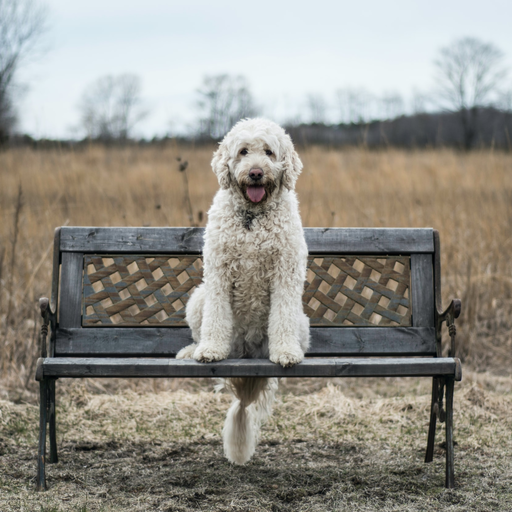

In [21]:
Image.fromarray(image_source)

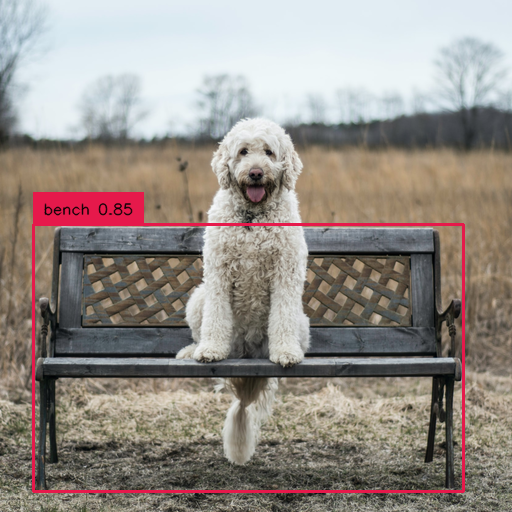

In [170]:
Image.fromarray(annotated_frame)

# Run the segmentation model

In [120]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  




In [ ]:
# set image
image_path = 'DOTA_v1.0_rar/val/images/images/P2802.png'
local_image_path = '/home/datadisk/evaluation/data/Benchmark/datasets/'+image_path

image_source, image = load_image(local_image_path)

sam_predictor.set_image(image_source)
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
# boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

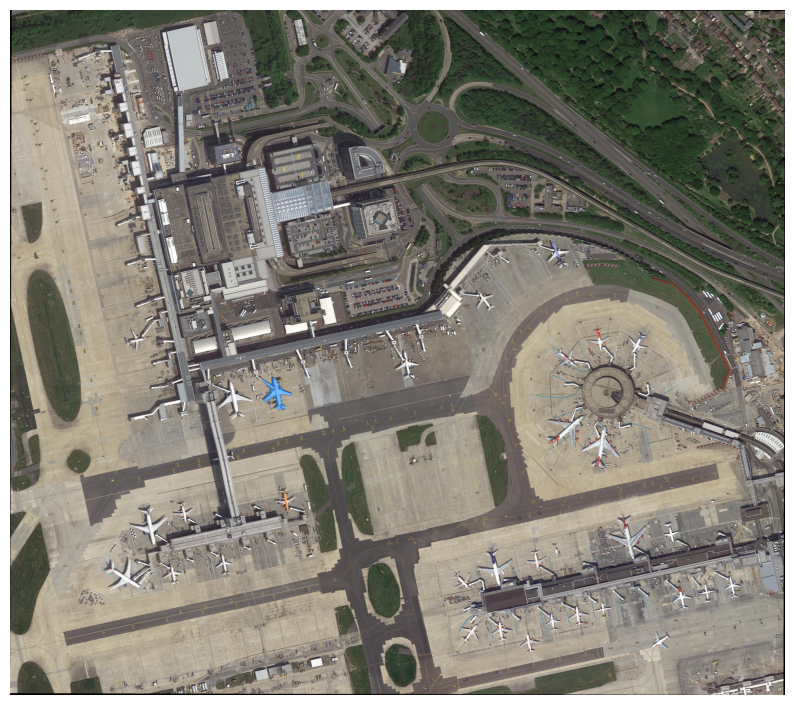

In [133]:
# x_point = 2064.0
# y_point = 3654.0
# w_point = 21.0
# h_point = 30.0

x_point = 1947.0
y_point = 2820.0
w_point = 224.0
h_point = 257.0




# input_boxes = torch.tensor([
#     bbox,
#     [1947.0, 2820.0, 1947.0+224.0, 2820.0+ 257.0]
# ], device=sam_predictor.device)

# transformed_boxes = sam_predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])


# masks, _, _ = sam_predictor.predict_torch(
#             point_coords = None,
#             point_labels = None,
#             boxes = transformed_boxes,
#             multimask_output = False,
#         )
# plt.figure(figsize=(10, 10))
# plt.imshow(image_source)
# for mask in masks:
#     show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box.cpu().numpy(), plt.gca())
# plt.axis('off')
# plt.show()

bbox = [x_point, y_point, x_point+w_point, y_point+h_point]

input_box = np.array(bbox)

masks, _, _ = sam_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)


plt.figure(figsize=(10, 10))
plt.imshow(image_source)
show_mask(masks[0], plt.gca())
#show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [65]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [66]:
annotated_frame_with_mask = show_mask(masks[0][0].cpu(), image_source)

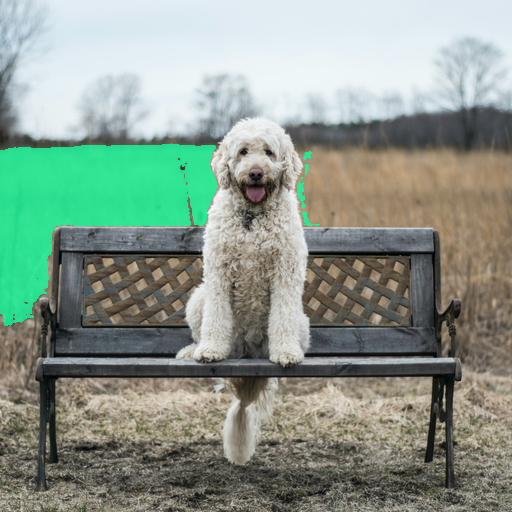

In [67]:
Image.fromarray(annotated_frame_with_mask)

# Image Inpainting

In [177]:
image_mask = masks[0][0].cpu().numpy()

In [178]:
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

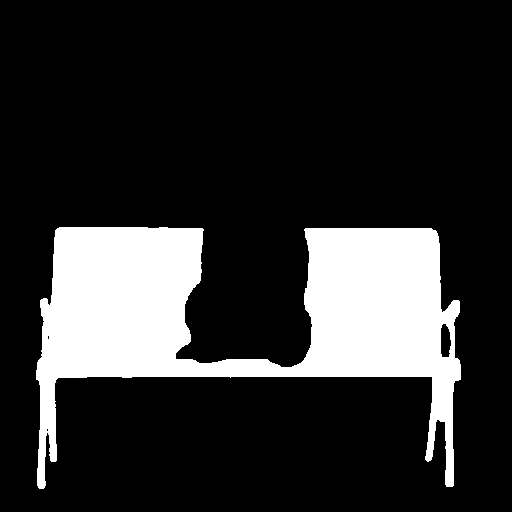

In [179]:
image_mask_pil

In [181]:
# resize for inpaint
image_source_for_inpaint = image_source_pil.resize((512, 512))
image_mask_for_inpaint = image_mask_pil.resize((512, 512))

In [182]:
prompt = "A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]

100%|██████████| 50/50 [00:02<00:00, 17.54it/s]


In [183]:
image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))

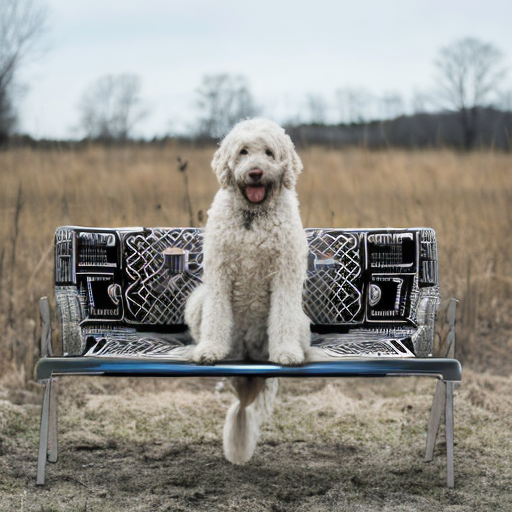

In [184]:
image_inpainting